In [1]:
from RandomForest import RandomForest
from DecisionTree import DecisionTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
from preprocessing import *
from plot_tree import plot_tree
np.random.seed(42)
random.seed(42)

In [2]:
data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### It seems there are no values we need to fill by ourselves since there are no NULL values right? Wrong. While there are no NULL values, there are still values that are missing and they were replaced with 0.

In [4]:
print(data.eq(0).sum(axis=0))

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


#### We can see that there are values that are 0 for most of the columns. However we should also consider if a column can have a 0 value naturally such as 'Pregnancies' (which is the only column that is allowed to have a value 0, other columns having 0 would cause the person to be identified as dead).
#### We will group the columns ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']  by their outcome and fill them with the median of that column as a preprocessing step.

In [5]:
data = replace_zeros_with_median_considering_outcome(data, columns_to_fill=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'])

#### Now we can see what our data looks like using histograms

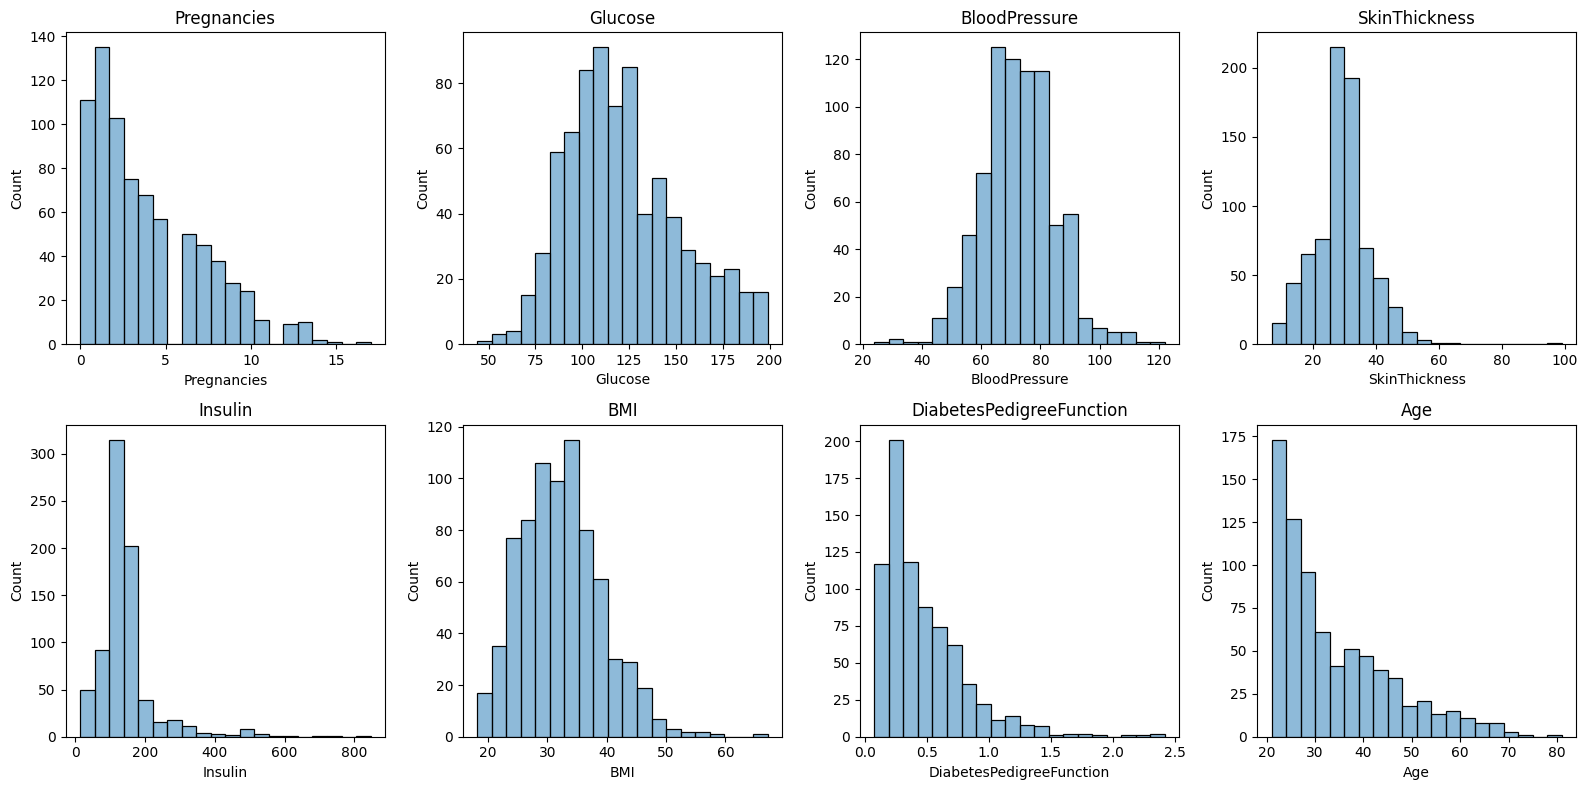

In [6]:
plt.figure(figsize=(16, 8))

counter = 1
for column in data.columns[:-1]:
    plt.subplot(2, 4, counter)
    sns.histplot(data[column], alpha=0.5, bins=20)
    plt.title(column)
    counter += 1

plt.tight_layout()
plt.show()

#### We can see a few outliers in some of the histograms. Lets find them by setting quantile ranges

In [7]:
lower_quantile = 0.03
upper_quantile = 0.97

# Outliers for each column
outliers = data[(data < data.quantile(lower_quantile)) | (data > data.quantile(upper_quantile))]

print("Number of Outliers:")
print(outliers.apply(lambda x: x.count()))


Number of Outliers:
Pregnancies                 23
Glucose                     47
BloodPressure               40
SkinThickness               45
Insulin                     46
BMI                         44
DiabetesPedigreeFunction    48
Age                         21
Outcome                      0
dtype: int64


#### So we have some outliers for every column, We can set them to the lower or upper quartile based on which of them they are closer to. However doing this made my f1-score worse ([[49  6] [13 86]]) vs Confusion matrix: [[49  6] [12 87]] So I am skipping this, however the code is still here



In [8]:
# data = data.apply(lambda x: x.clip(lower=x.quantile(lower_quantile), upper=x.quantile(upper_quantile)))

#### After the preprocessing steps, we can explore our data. First let's start with a simple correlation matrix

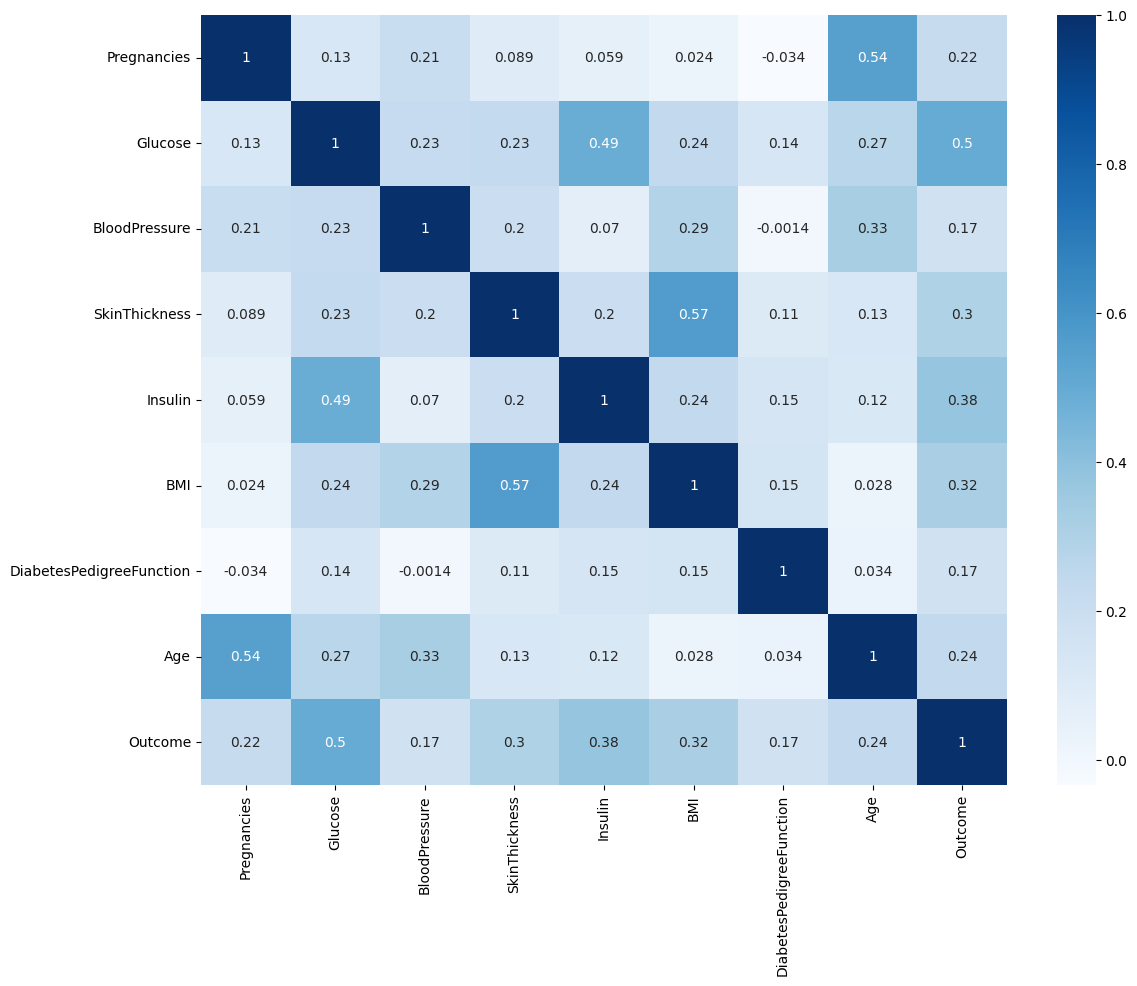

In [9]:
corr = data.corr()
plt.figure(figsize=(13,10))

sns.heatmap(corr, cmap='Blues', annot=True)
plt.show()

#### We can see by checking the Outcome row, which of the columns have the most affect on the outcome. Number 1 factor is Glucose rate in the blood. Each of the columns seems to have a positive correlation with the outcome.

#### Now that we are done with the preprocessing steps, we can train and test our models. We start by splitting the data into 80% training and %20 testing data which is the standart split ratio.

In [10]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)


#### We can then fit the training data to our classifier and predict on our test data to get our metrics which we can then use to evaluate the data

In [16]:
max_depth = 4

# classifier = DecisionTree(max_depth=max_depth , criteria='gini')
classifier = DecisionTree(max_depth=max_depth , criteria='entropy')


classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f"Confusion matrix: \n{classifier.confusion_matrix(y_test, y_pred)}")
accuracy, precision, recall, f1 = classifier.metrics(classifier.confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")


Confusion matrix: 
[[49  6]
 [12 87]]
Accuracy: 0.8831168831168831
Precision: 0.8032786885245902
Recall: 0.8909090909090909
F1: 0.8448275862068965


#### Note that our implementaion of confusion matrix = [[TP, FN] , [FP, TN]].
#### All our metrics are above 0.8 which is decent. For our scenario, which is diabetes prediction we want to minimize the false negative (actual positive) cases which might have more implications for the patient (Letting a patient go without prescription or anything). So the metric we care most about in this case would be Recall. And it is very high with our Random Forest classifier with max_depth = 4. 

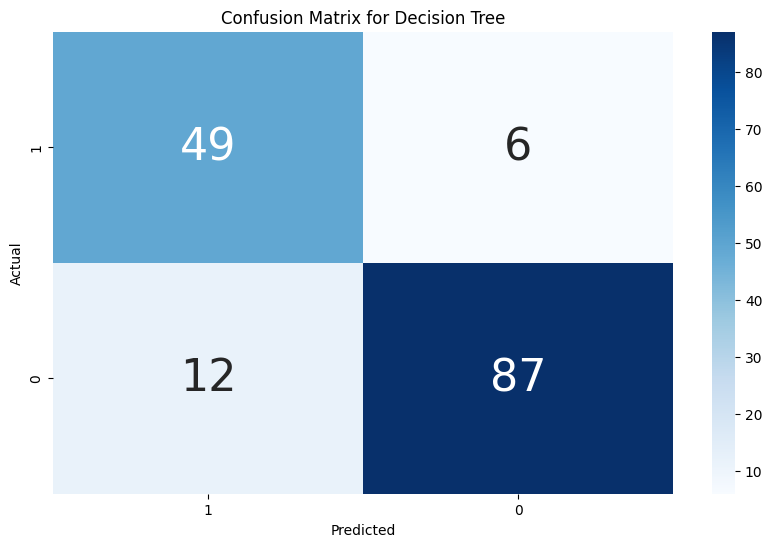

In [12]:
plt.figure(figsize=(10,6))
confusion_matrix = classifier.confusion_matrix(y_test, y_pred)
confusion_matrix[0][0], confusion_matrix[1][1] = confusion_matrix[1][1], confusion_matrix[0][0]
confusion_matrix[0][1], confusion_matrix[1][0] = confusion_matrix[1][0], confusion_matrix[0][1]
sns.heatmap(confusion_matrix, annot=True ,fmt='d', cmap='Blues',annot_kws={"size": 32})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()


#### One thing that decision trees does good is that they are not a classifier, meaning that we can interpret why the classifier made the choice that it did. This of course is great in our case for the patients to see why they were predicted to have diabetes or not. We can do this by plotting the decision tree

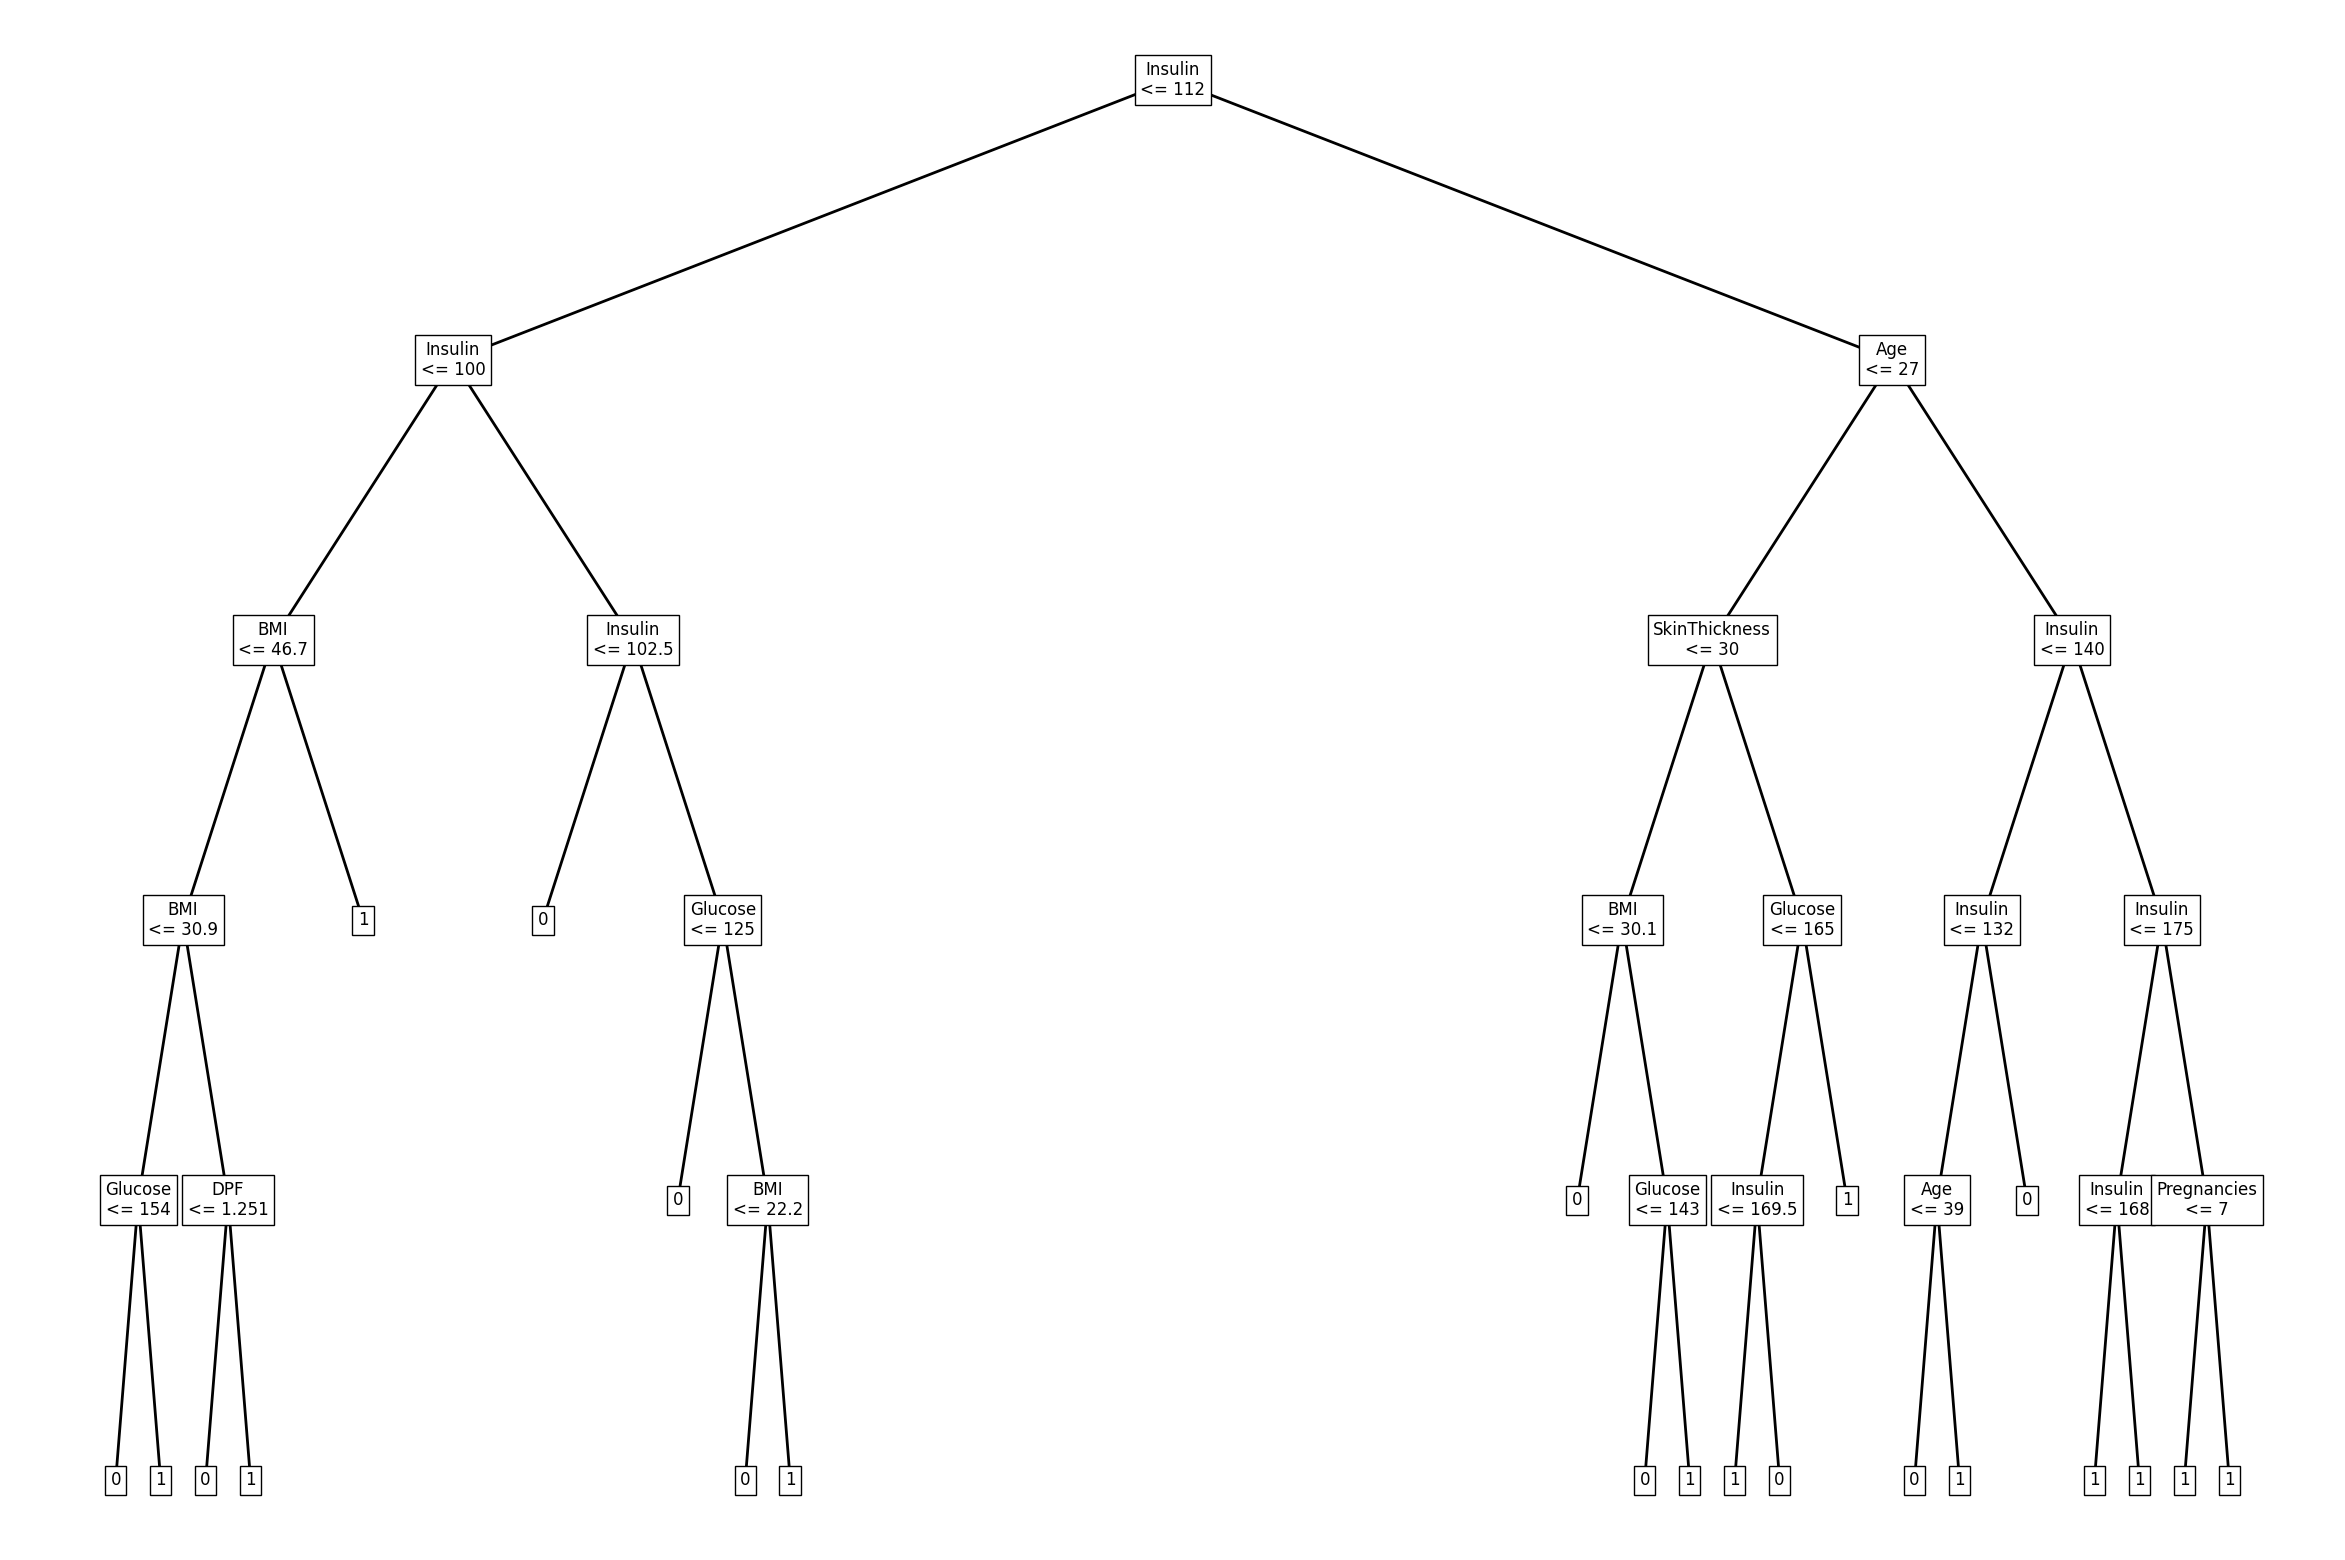

In [13]:
DPF_renamed = data.copy()
DPF_renamed = DPF_renamed.rename(columns={'DiabetesPedigreeFunction': 'DPF'})
feature_names = DPF_renamed.columns[:-1]

if max_depth == 4:
    plt.figure(figsize=(30, 20))
if max_depth <= 3:
    plt.figure(figsize=(16, 9))
plot_tree(classifier.root, feature_names, max_depth=max_depth)
plt.axis('off')
plt.show()

#### This is the decision tree visualized! If we want to we can see the label that the classifier will predict manually by looking at the tree.

#### This part is the Random Forest algorithm, where random parts of the data will be selected and put into decision trees. After all the decision trees have been trained the model will predict the data by majority vote, where each tree gets to vote on the decision and the outcome with the most labels wins

In [15]:
classifier2 = RandomForest(25, max_depth=3)
classifier2.fit(X_train, y_train)
y_pred = classifier2.predict(X_test)
print(f"Confusion matrix: \n{classifier.confusion_matrix(y_test, y_pred)}")
accuracy, precision, recall, f1 = classifier.metrics(classifier.confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")


Confusion matrix: 
[[47  8]
 [11 88]]
Accuracy: 0.8766233766233766
Precision: 0.8103448275862069
Recall: 0.8545454545454545
F1: 0.831858407079646


#### Since the sampling is random, the metrics fluctuate a lot when the model is reset and trained again which makes it hard to adjust parameters. Despite this I found that increasing the depth led to recall loss so I decided to stick with 3 which usually has a nice Recall measure.

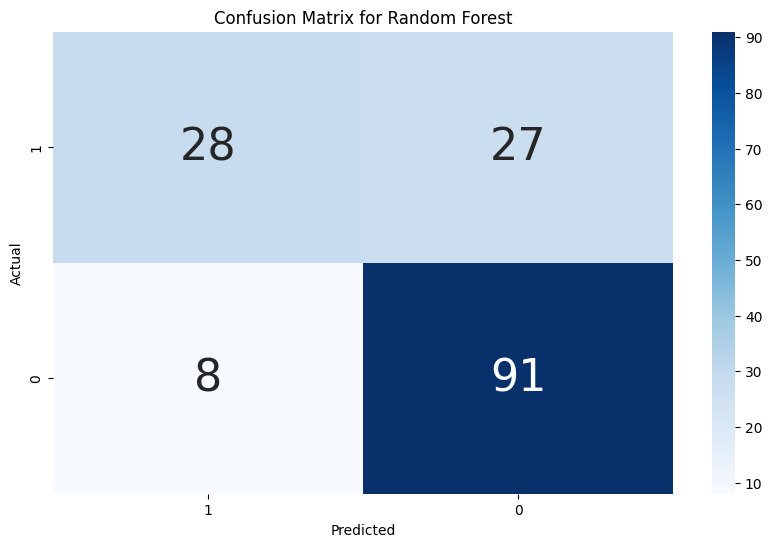

In [10]:

plt.figure(figsize=(10,6))
confusion_matrix = classifier.confusion_matrix(y_test, y_pred)
confusion_matrix[0][0], confusion_matrix[1][1] = confusion_matrix[1][1], confusion_matrix[0][0]
confusion_matrix[0][1], confusion_matrix[1][0] = confusion_matrix[1][0], confusion_matrix[0][1]
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',annot_kws={"size": 32})

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
